In [1]:
!pip install timm torch torchvision

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
import warnings
import sys
from tqdm import tqdm
import time
import copy
import timm
from timm.loss.binary_cross_entropy import BinaryCrossEntropy
warnings.filterwarnings("ignore")

In [3]:
def get_data_loaders(batch_size, train=False):
    if train:
        # Image augmentation for train data
        transform = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.05, contrast=0.05),
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # ImageNet mean and stdev
            T.RandomErasing(p=0.05, value='random')
        ])
        
        train_data_path = '/kaggle/input/cropped-and-balanced-openforensics-data/train_cropped_faces_224_rgb_balanced/Train'
        train_data = datasets.ImageFolder(train_data_path, transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, train_data
    else:
        # No image augmentation for val and test data
        transform = T.Compose([
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet mean and stdev
        ])
        
        val_data_path = '/kaggle/input/cropped-and-balanced-openforensics-data/val_cropped_faces_224_rgb/Val'
        test_data_path = '/kaggle/input/cropped-and-balanced-openforensics-data/test_cropped_faces_224_rgb/Test'
        
        val_data = datasets.ImageFolder(val_data_path, transform=transform)
        test_data = datasets.ImageFolder(test_data_path, transform=transform)
        
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, val_data, test_data

In [4]:
(train_loader, train_data) = get_data_loaders(batch_size=128, train=True)
(val_loader, test_loader, val_data, test_data) = get_data_loaders(batch_size=32, train=False)

In [5]:
print(train_data.class_to_idx)
print(val_data.class_to_idx)
print(test_data.class_to_idx)

{'Fake': 0, 'Real': 1}
{'Fake': 0, 'Real': 1}
{'Fake': 0, 'Real': 1}


In [6]:
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}
dataset_sizes = {
    'train': len(train_data),
    'val': len(val_data),
    'test': len(test_data)
}

In [7]:
print('Train, val, and test data size:')
dataset_sizes['train'], dataset_sizes['val'], dataset_sizes['test']

Train, val, and test data size:


(131720, 15345, 49718)

In [8]:
classes = ['Fake', 'Real']

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Vision Transformer (ViT)

In [37]:
timm.models.list_models('vit*')

['vit_base_mci_224',
 'vit_base_patch8_224',
 'vit_base_patch14_dinov2',
 'vit_base_patch14_reg4_dinov2',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_clip_quickgelu_224',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_plus_clip_240',
 'vit_base_patch16_reg4_gap_256',
 'vit_base_patch16_rope_reg1_gap_256',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_siglip_224',
 'vit_base_patch16_siglip_256',
 'vit_base_patch16_siglip_384',
 'vit_base_patch16_siglip_512',
 'vit_base_patch16_siglip_gap_224',
 'vit_base_patch16_siglip_gap_256',
 'vit_base_patch16_siglip_gap_384',
 'vit_base_patch16_siglip_gap_512',
 'vit_base_patch16_xp_224',
 'vit_base_patch32_224',
 'vit_base_patch32_384',
 'vit_base_patch32_clip_224',
 'vit_base_patch32_clip_256',
 'vit_base_patch32_clip_384',
 'vit_base_patch32_clip_448',
 'vit_base_patch32

In [38]:
# ViT Tiny (timm)
vit_model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2)

In [39]:
for param in vit_model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = vit_model.head.in_features
vit_model.head = nn.Sequential(
    nn.Linear(n_inputs, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
)

vit_model = vit_model.to(device)
vit_model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [10]:
def calculate_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,}")

In [41]:
calculate_parameters(vit_model)

Total parameters: 5,532,769
Trainable parameters: 8,353


In [42]:
criterion = BinaryCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(vit_model.head.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        print("=" * 20)

        epoch_stats = {
            'train': {'loss': 0, 'acc': 0, 'precision': 0, 'recall': 0, 'f1': 0},
            'val': {'loss': 0, 'acc': 0, 'precision': 0, 'recall': 0, 'f1': 0}
        }
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0
            
            all_preds = []
            all_labels = []
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = outputs.squeeze(1)  # Flatten output to [batch_size]
                    preds = (torch.sigmoid(outputs) > 0.5).float()  # Predictions
                    loss = criterion(outputs, labels.float())  # Compute loss
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.float())  # Compare predictions

                all_preds.extend(preds.cpu().numpy())  # Store all predictions
                all_labels.extend(labels.cpu().numpy())  # Store all labels

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Calculate precision, recall, and F1 score
            precision = precision_score(all_labels, all_preds, zero_division=0)
            recall = recall_score(all_labels, all_preds, zero_division=0)
            f1 = f1_score(all_labels, all_preds, zero_division=0)
            
            # Update epoch stats
            epoch_stats[phase]['loss'] = epoch_loss
            epoch_stats[phase]['acc'] = epoch_acc.item()
            epoch_stats[phase]['precision'] = precision
            epoch_stats[phase]['recall'] = recall
            epoch_stats[phase]['f1'] = f1
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} "
                  f"Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}")
            
            # Save the best model based on F1 score or other metrics (optional)
            if phase == 'val' and f1 > best_acc:
                best_acc = f1
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print('-' * 20)
    
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val F1: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [44]:
vit_model_history = train_model(vit_model, criterion, optimizer, exp_lr_scheduler)


Epoch 1/5


100%|██████████| 1030/1030 [04:34<00:00,  3.75it/s]


train Loss: 0.2798 Acc: 0.8772 Precision: 0.8781 Recall: 0.8760 F1: 0.8770


100%|██████████| 480/480 [00:23<00:00, 20.55it/s]


val Loss: 0.2759 Acc: 0.8845 Precision: 0.7993 Recall: 0.8402 F1: 0.8192
--------------------

Epoch 2/5


100%|██████████| 1030/1030 [03:42<00:00,  4.62it/s]


train Loss: 0.2166 Acc: 0.9092 Precision: 0.9083 Recall: 0.9102 F1: 0.9093


100%|██████████| 480/480 [00:18<00:00, 26.61it/s]


val Loss: 0.2521 Acc: 0.8983 Precision: 0.8794 Recall: 0.7808 F1: 0.8272
--------------------

Epoch 3/5


100%|██████████| 1030/1030 [03:43<00:00,  4.61it/s]


train Loss: 0.2011 Acc: 0.9153 Precision: 0.9142 Recall: 0.9167 F1: 0.9155


100%|██████████| 480/480 [00:18<00:00, 25.92it/s]


val Loss: 0.2573 Acc: 0.8994 Precision: 0.9181 Recall: 0.7434 F1: 0.8216
--------------------

Epoch 4/5


100%|██████████| 1030/1030 [03:41<00:00,  4.64it/s]


train Loss: 0.1910 Acc: 0.9206 Precision: 0.9196 Recall: 0.9217 F1: 0.9206


100%|██████████| 480/480 [00:18<00:00, 26.49it/s]


val Loss: 0.2551 Acc: 0.9007 Precision: 0.9110 Recall: 0.7553 F1: 0.8259
--------------------

Epoch 5/5


100%|██████████| 1030/1030 [03:42<00:00,  4.63it/s]


train Loss: 0.1823 Acc: 0.9246 Precision: 0.9234 Recall: 0.9261 F1: 0.9247


100%|██████████| 480/480 [00:18<00:00, 26.02it/s]


val Loss: 0.2374 Acc: 0.9068 Precision: 0.9112 Recall: 0.7767 F1: 0.8386
--------------------
Training completed in 21m 3s
Best Val F1: 0.8386


In [45]:
all_preds = []
all_targets = []

# Switch model to evaluation mode
vit_model.eval()

# Loop over test data
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = vit_model(inputs)
        outputs = outputs.squeeze(1)  # Ensure outputs are [batch_size]
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Threshold predictions (binary)
    
    # Store predictions and targets
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())

# Convert predictions and targets to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

100%|██████████| 1554/1554 [01:18<00:00, 19.79it/s]


In [46]:
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

        Fake       0.90      0.96      0.93     28670
        Real       0.95      0.86      0.90     21048

    accuracy                           0.92     49718
   macro avg       0.92      0.91      0.91     49718
weighted avg       0.92      0.92      0.92     49718



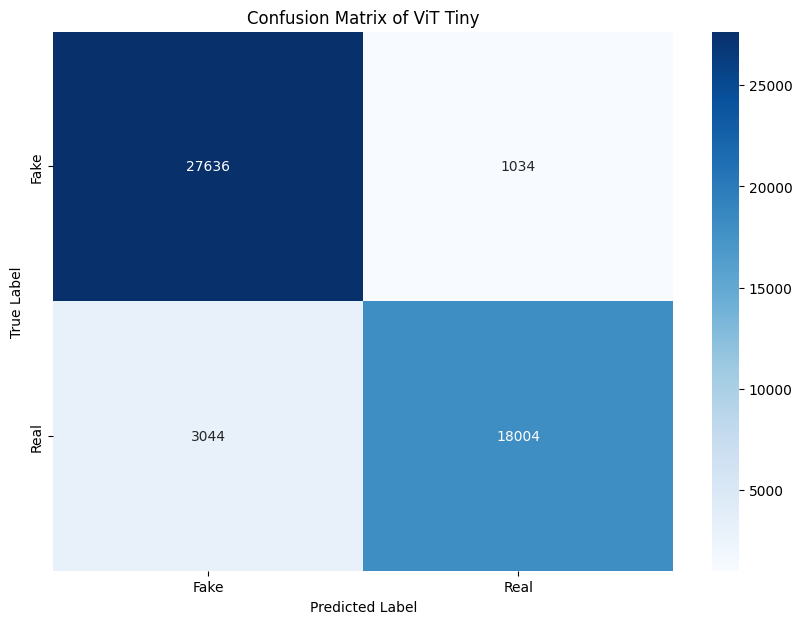

In [47]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix of ViT Tiny')
plt.show()

In [48]:
torch.save(vit_model.state_dict(), 'vit_tiny_patch16_224_5_epochs_balanced_lr_1emin3.pth')

In [49]:
# torch.save(vit_model.state_dict(), 'vit_tiny_patch16_224_5_epochs_balanced_lr_1emin4.pth')

# Cross-Covariance Image Transformer (XCiT)

In [50]:
timm.models.list_models('xcit*')

['xcit_large_24_p8_224',
 'xcit_large_24_p8_384',
 'xcit_large_24_p16_224',
 'xcit_large_24_p16_384',
 'xcit_medium_24_p8_224',
 'xcit_medium_24_p8_384',
 'xcit_medium_24_p16_224',
 'xcit_medium_24_p16_384',
 'xcit_nano_12_p8_224',
 'xcit_nano_12_p8_384',
 'xcit_nano_12_p16_224',
 'xcit_nano_12_p16_384',
 'xcit_small_12_p8_224',
 'xcit_small_12_p8_384',
 'xcit_small_12_p16_224',
 'xcit_small_12_p16_384',
 'xcit_small_24_p8_224',
 'xcit_small_24_p8_384',
 'xcit_small_24_p16_224',
 'xcit_small_24_p16_384',
 'xcit_tiny_12_p8_224',
 'xcit_tiny_12_p8_384',
 'xcit_tiny_12_p16_224',
 'xcit_tiny_12_p16_384',
 'xcit_tiny_24_p8_224',
 'xcit_tiny_24_p8_384',
 'xcit_tiny_24_p16_224',
 'xcit_tiny_24_p16_384']

In [51]:
xcit_model = timm.create_model('xcit_tiny_12_p16_224', pretrained=True, num_classes=2)

In [52]:
for param in xcit_model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = xcit_model.head.in_features
xcit_model.head = nn.Sequential(
    nn.Linear(n_inputs, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
)

xcit_model = xcit_model.to(device)
xcit_model

Xcit(
  (patch_embed): ConvPatchEmbed(
    (proj): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GELU(approximate='none')
      (2): Sequential(
        (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): GELU(approximate='none')
      (4): Sequential(
        (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (5): GELU(approximate='none')
      (6): Sequential(
        (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, tr

In [53]:
calculate_parameters(xcit_model)

Total parameters: 6,531,625
Trainable parameters: 8,353


In [54]:
criterion = BinaryCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(xcit_model.head.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [55]:
xcit_model_history = train_model(xcit_model, criterion, optimizer, exp_lr_scheduler)


Epoch 1/5


100%|██████████| 1030/1030 [04:05<00:00,  4.19it/s]


train Loss: 0.2691 Acc: 0.8844 Precision: 0.8868 Recall: 0.8813 F1: 0.8841


100%|██████████| 480/480 [00:24<00:00, 19.82it/s]


val Loss: 0.3015 Acc: 0.8739 Precision: 0.8190 Recall: 0.7643 F1: 0.7907
--------------------

Epoch 2/5


100%|██████████| 1030/1030 [04:04<00:00,  4.21it/s]


train Loss: 0.2104 Acc: 0.9113 Precision: 0.9105 Recall: 0.9122 F1: 0.9113


100%|██████████| 480/480 [00:23<00:00, 20.69it/s]


val Loss: 0.2684 Acc: 0.8920 Precision: 0.8387 Recall: 0.8091 F1: 0.8236
--------------------

Epoch 3/5


100%|██████████| 1030/1030 [04:06<00:00,  4.19it/s]


train Loss: 0.1954 Acc: 0.9189 Precision: 0.9166 Recall: 0.9216 F1: 0.9191


100%|██████████| 480/480 [00:23<00:00, 20.76it/s]


val Loss: 0.2537 Acc: 0.8944 Precision: 0.8729 Recall: 0.7739 F1: 0.8204
--------------------

Epoch 4/5


100%|██████████| 1030/1030 [04:06<00:00,  4.18it/s]


train Loss: 0.1872 Acc: 0.9222 Precision: 0.9197 Recall: 0.9252 F1: 0.9224


100%|██████████| 480/480 [00:23<00:00, 20.54it/s]


val Loss: 0.2595 Acc: 0.8910 Precision: 0.8303 Recall: 0.8172 F1: 0.8237
--------------------

Epoch 5/5


100%|██████████| 1030/1030 [04:15<00:00,  4.03it/s]


train Loss: 0.1831 Acc: 0.9242 Precision: 0.9218 Recall: 0.9270 F1: 0.9244


100%|██████████| 480/480 [00:23<00:00, 20.58it/s]


val Loss: 0.2525 Acc: 0.8980 Precision: 0.8822 Recall: 0.7765 F1: 0.8259
--------------------
Training completed in 22m 37s
Best Val F1: 0.8259


In [56]:
# all_preds = []
# all_targets = []

# xcit_model_history.eval()
# for data, target in tqdm(test_loader):
#     data, target = data.to(device), target.to(device)
#     with torch.no_grad():
#         output = xcit_model_history(data)
#         _, pred = torch.max(output, 1)
        
#     all_preds.extend(pred.cpu().numpy())
#     all_targets.extend(target.cpu().numpy())

In [57]:
all_preds = []
all_targets = []

# Switch model to evaluation mode
xcit_model.eval()

# Loop over test data
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = xcit_model(inputs)
        outputs = outputs.squeeze(1)  # Ensure outputs are [batch_size]
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Threshold predictions (binary)
    
    # Store predictions and targets
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())

# Convert predictions and targets to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

100%|██████████| 1554/1554 [01:14<00:00, 20.90it/s]


In [58]:
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

        Fake       0.91      0.95      0.93     28670
        Real       0.93      0.87      0.90     21048

    accuracy                           0.92     49718
   macro avg       0.92      0.91      0.91     49718
weighted avg       0.92      0.92      0.92     49718



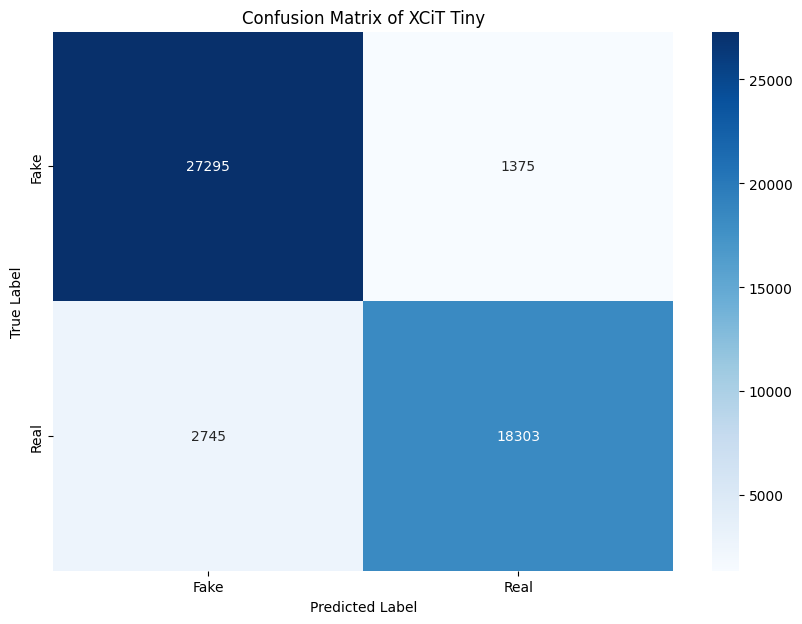

In [59]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix of XCiT Tiny')
plt.show()

In [60]:
torch.save(xcit_model.state_dict(), 'xcit_tiny_patch16_224_5_epochs_balanced_lr_1emin3.pth')

In [61]:
# torch.save(xcit_model.state_dict(), 'xcit_tiny_patch16_224_5_epochs_balanced_lr_1emin4.pth')

# Data-Efficient Image Transformer (DeiT)

In [12]:
timm.models.list_models('deit*')

['deit3_base_patch16_224',
 'deit3_base_patch16_384',
 'deit3_huge_patch14_224',
 'deit3_large_patch16_224',
 'deit3_large_patch16_384',
 'deit3_medium_patch16_224',
 'deit3_small_patch16_224',
 'deit3_small_patch16_384',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224']

In [13]:
# DeiT Tiny (Facebook Research)
deit_model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_patch16_224-a1311bcf.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_patch16_224-a1311bcf.pth
100%|██████████| 21.9M/21.9M [00:00<00:00, 149MB/s]


In [14]:
for param in deit_model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = deit_model.head.in_features
deit_model.head = nn.Sequential(
    nn.Linear(n_inputs, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
)

deit_model = deit_model.to(device)
deit_model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [15]:
calculate_parameters(deit_model)

Total parameters: 5,532,769
Trainable parameters: 8,353


In [16]:
criterion = BinaryCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(deit_model.head.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [17]:
deit_model_history = train_model(deit_model, criterion, optimizer, exp_lr_scheduler)


Epoch 1/5


100%|██████████| 1030/1030 [04:50<00:00,  3.54it/s]


train Loss: 0.3027 Acc: 0.8672 Precision: 0.8653 Recall: 0.8698 F1: 0.8676


100%|██████████| 480/480 [00:27<00:00, 17.78it/s]


val Loss: 0.3093 Acc: 0.8761 Precision: 0.8918 Recall: 0.6857 F1: 0.7753
--------------------

Epoch 2/5


100%|██████████| 1030/1030 [03:42<00:00,  4.62it/s]


train Loss: 0.2422 Acc: 0.8974 Precision: 0.8932 Recall: 0.9029 F1: 0.8980


100%|██████████| 480/480 [00:19<00:00, 24.70it/s]


val Loss: 0.2831 Acc: 0.8873 Precision: 0.8840 Recall: 0.7348 F1: 0.8026
--------------------

Epoch 3/5


100%|██████████| 1030/1030 [03:40<00:00,  4.67it/s]


train Loss: 0.2258 Acc: 0.9059 Precision: 0.9012 Recall: 0.9118 F1: 0.9065


100%|██████████| 480/480 [00:18<00:00, 25.38it/s]


val Loss: 0.2639 Acc: 0.8926 Precision: 0.8888 Recall: 0.7491 F1: 0.8130
--------------------

Epoch 4/5


100%|██████████| 1030/1030 [03:39<00:00,  4.69it/s]


train Loss: 0.2146 Acc: 0.9094 Precision: 0.9039 Recall: 0.9162 F1: 0.9100


100%|██████████| 480/480 [00:19<00:00, 24.69it/s]


val Loss: 0.2662 Acc: 0.8929 Precision: 0.8929 Recall: 0.7459 F1: 0.8128
--------------------

Epoch 5/5


100%|██████████| 1030/1030 [03:44<00:00,  4.60it/s]


train Loss: 0.2073 Acc: 0.9137 Precision: 0.9080 Recall: 0.9207 F1: 0.9143


100%|██████████| 480/480 [00:19<00:00, 25.09it/s]


val Loss: 0.2529 Acc: 0.8969 Precision: 0.8910 Recall: 0.7624 F1: 0.8217
--------------------
Training completed in 21m 24s
Best Val F1: 0.8217


In [18]:
all_preds = []
all_targets = []

# Switch model to evaluation mode
deit_model.eval()

# Loop over test data
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = deit_model(inputs)
        outputs = outputs.squeeze(1)  # Ensure outputs are [batch_size]
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Threshold predictions (binary)
    
    # Store predictions and targets
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())

# Convert predictions and targets to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

100%|██████████| 1554/1554 [01:38<00:00, 15.80it/s]


In [19]:
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

        Fake       0.90      0.95      0.92     28670
        Real       0.93      0.85      0.89     21048

    accuracy                           0.91     49718
   macro avg       0.91      0.90      0.91     49718
weighted avg       0.91      0.91      0.91     49718



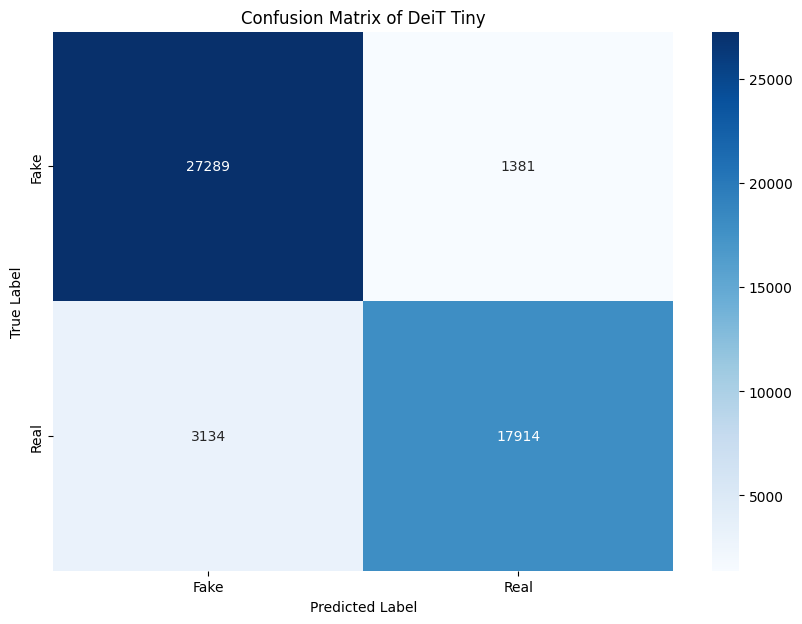

In [20]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix of DeiT Tiny')
plt.show()

In [21]:
torch.save(deit_model.state_dict(), 'deit_tiny_patch16_224_5_epochs_balanced_lr_1emin3.pth')

In [ ]:
# torch.save(deit_model.state_dict(), 'deit_tiny_patch16_224_5_epochs_balanced_lr_1emin4.pth')